# Veg ET validation

In [1]:
import pandas as pd
from time import time
import xarray as xr
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from scipy import stats
import matplotlib.patches as mpatches

In [25]:
#! aws s3 ls dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/

In [2]:
def _get_year_month(product, tif):
    fn = tif.split('/')[-1]
    fn = fn.replace(product,'')
    fn = fn.replace('.tif','')
    fn = fn.replace('_','')
    print(fn)
    return fn

In [3]:
def _file_object(bucket_prefix,product_name,year,day):
    if product_name == 'NDVI':
        decade = str(year)[:3]+'0'
        variable_prefix = bucket_prefix + 'NDVI_FORE_SCE_MED/delaware_basin_FS_'
        file_object = variable_prefix  + str(decade) + '/' + 'FS_{0}_{1}_med_{2}.tif'.format(str(decade), product_name, day)
    elif product_name == 'ETo':
        decade = str(year)[:3]+'0'
        variable_prefix = bucket_prefix +'ETo_Moving_Average_byDOY/'
        file_object =  variable_prefix + '{0}_{1}/'.format(str(decade), str(int(decade)+10)) + '{0}_DOY{1}.tif'.format(product_name,day)
    elif product_name == 'Tasavg' or product_name == 'Tasmax' or product_name == 'Tasmin':
        variable_prefix = bucket_prefix + 'TempCelsius/' + product_name + '/'
        file_object = variable_prefix  + str(year) + '/' + '{}_'.format(product_name) + str(year) + day + '.tif'
    elif product_name == 'PPT':
        variable_prefix = bucket_prefix + product_name + '/'
        file_object = variable_prefix  + str(year) + '/' + '{}_'.format(product_name) + str(year) + day + '.tif'
    else:
        file_object = bucket_prefix  + str(start_year) + '/' + f'{product_name}_' + str(start_year) + day + '.tif'
    return file_object

In [4]:
def create_s3_list_of_days_start_end(main_bucket_prefix, start_year,start_day, end_year, end_day, product_name):
    the_list = []
    years = []
    for year in (range(int(start_year),int(end_year)+1)):
        years.append(year)
    if len(years) == 1:
        for i in range(int(start_day),int(end_day)):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,start_year,day)
            the_list.append(file_object)
    elif len(years) == 2:
        for i in range(int(start_day),366):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,start_year,day)
            the_list.append(file_object)
        for i in range(1,int(end_day)):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,end_year,day)
            the_list.append(file_object)
    else:
        for i in range(int(start_day),366):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,start_year,day)
            the_list.append(file_object)
        for year in years[1:-1]:
            for i in range(1,366):
                day = f'{i:03d}'
                file_object = _file_object(main_bucket_prefix,product_name,year,day)
                the_list.append(file_object)
        for i in range(1,int(end_day)):
            day = f'{i:03d}'
            file_object = _file_object(main_bucket_prefix,product_name,end_year,day)
            the_list.append(file_object)
    return the_list

In [5]:
def xr_build_cube_concat_ds_one(tif_list, product, x, y):
    start = time()
    my_da_list =[]
    year_month_list = []
    for tif in tif_list:
        #tiffile = 's3://dev-et-data/' + tif
        tiffile = tif
        print(tiffile)
        da = xr.open_rasterio(tiffile)
        daSub = da.sel(x=x, y=y, method='nearest')
        #da = da.squeeze().drop(labels='band')
        #da.name=product
        my_da_list.append(daSub)
        tnow = time()
        elapsed = tnow - start
        print(tif, elapsed)
        year_month_list.append(_get_year_month(product, tif))

    da = xr.concat(my_da_list, dim='band')
    da = da.rename({'band':'year_month'})
    da = da.assign_coords(year_month=year_month_list)
    DS = da.to_dataset(name=product)
    return(DS)

In [6]:
main_bucket_prefix='s3://dev-et-data/in/DelawareRiverBasin/'
start_year = '2000'
start_day = '1'
end_year = '2000'
end_day = '11'
# x - longitude
# y - latitude
x=-75
y=41

## Step 1: Get pixel values for model input variables

In [7]:
df_list=[]
for product in ['PPT','Tasavg', 'Tasmin', 'Tasmax', 'NDVI', 'ETo']:
    print("==="*30)
    print("processing product",product)
    tif_list = create_s3_list_of_days_start_end(main_bucket_prefix, start_year,start_day, end_year, end_day, product)
    print (tif_list)
    ds_pix=xr_build_cube_concat_ds_one(tif_list, product, x, y)
    my_index = ds_pix['year_month'].values
    my_array = ds_pix[product].values
    df = pd.DataFrame(my_array, columns=[product,], index=my_index)
    df_list.append(df)
    

processing product PPT
['s3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000001.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000002.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000003.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000004.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000005.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000006.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000007.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000008.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000009.tif', 's3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000010.tif']
s3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000001.tif
s3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000001.tif 8.282986164093018
2000001
s3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000002.tif
s3://dev-et-data/in/DelawareRiverBasin/PPT/2000/PPT_2000002.tif 15.961418390274048
20000

s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasmax/2000/Tasmax_2000001.tif 1.7053565979003906
2000001
s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasmax/2000/Tasmax_2000002.tif
s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasmax/2000/Tasmax_2000002.tif 3.9952731132507324
2000002
s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasmax/2000/Tasmax_2000003.tif
s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasmax/2000/Tasmax_2000003.tif 5.86603045463562
2000003
s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasmax/2000/Tasmax_2000004.tif
s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasmax/2000/Tasmax_2000004.tif 7.648117542266846
2000004
s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasmax/2000/Tasmax_2000005.tif
s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasmax/2000/Tasmax_2000005.tif 9.50410008430481
2000005
s3://dev-et-data/in/DelawareRiverBasin/TempCelsius/Tasmax/2000/Tasmax_2000006.tif
s3://dev-et-data/in/DelawareRiverBasin/TempCelsius

s3://dev-et-data/in/DelawareRiverBasin/ETo_Moving_Average_byDOY/2000_2010/ETo_DOY010.tif 17.470059871673584
DOY010


In [8]:
df_reset_list = []
for dframe in df_list:
    print (dframe)
    df_reset = dframe.set_index(df_list[0].index)
    print (df_reset)
    df_reset_list.append(df_reset)
df_veget = pd.concat(df_reset_list, axis=1)
df_veget['NDVI'] *= 0.0001
df_veget

          PPT
2000001   0.0
2000002   0.0
2000003   0.0
2000004   8.4
2000005   0.0
2000006   0.0
2000007   0.0
2000008   0.0
2000009   0.0
2000010  22.2
          PPT
2000001   0.0
2000002   0.0
2000003   0.0
2000004   8.4
2000005   0.0
2000006   0.0
2000007   0.0
2000008   0.0
2000009   0.0
2000010  22.2
           Tasavg
2000001 -1.191772
2000002 -2.310638
2000003 -3.607513
2000004 -2.447784
2000005 -0.460785
2000006  1.428955
2000007  0.741211
2000008  3.035522
2000009  2.429535
2000010  5.114349
           Tasavg
2000001 -1.191772
2000002 -2.310638
2000003 -3.607513
2000004 -2.447784
2000005 -0.460785
2000006  1.428955
2000007  0.741211
2000008  3.035522
2000009  2.429535
2000010  5.114349
           Tasmin
2000001 -4.272369
2000002 -6.366669
2000003 -7.929810
2000004 -7.675751
2000005 -4.729889
2000006 -2.332855
2000007 -2.170837
2000008 -0.388519
2000009 -1.598541
2000010 -0.346405
           Tasmin
2000001 -4.272369
2000002 -6.366669
2000003 -7.929810
2000004 -7.675751
2000005 

,PPT,Tasavg,Tasmin,Tasmax,NDVI,ETo
2000001,0.0,-1.191772,-4.272369,1.888824,0.4115,1.69
2000002,0.0,-2.310638,-6.366669,1.745361,0.4039,0.83
2000003,0.0,-3.607513,-7.929810,0.714783,0.3971,1.66
2000004,8.4,-2.447784,-7.675751,2.780212,0.3910,1.28
2000005,0.0,-0.460785,-4.729889,3.808289,0.3856,1.03
2000006,0.0,1.428955,-2.332855,5.190765,0.3809,0.56
2000007,0.0,0.741211,-2.170837,3.653259,0.3767,0.62
2000008,0.0,3.035522,-0.388519,6.459564,0.3731,0.98
2000009,0.0,2.429535,-1.598541,6.457581,0.3699,1.04
2000010,22.2,5.114349,-0.346405,10.575073,0.3672,0.78


In [9]:
for static_product in ['awc', 'por', 'fc', 'intercept', 'water']:
    if static_product == 'awc' or static_product == 'por' or static_product == 'fc':
        file_object = ['s3://dev-et-data/in/NorthAmerica/Soil/' + '{}_NA_mosaic.tif'.format(static_product)]
    elif static_product == 'intercept':
        #file_object = ['s3://dev-et-data/in/NorthAmerica/Soil/' + 'Intercept2016_nowater_int.tif']
        file_object =  ['s3://dev-et-data/in/NorthAmerica/Soil/' + 'intercept_filled_0_na.tif']
    else:
        file_object = ['s3://dev-et-data/in/DelawareRiverBasin/' + 'DRB_water_mask_inland.tif']
    ds_pix=xr_build_cube_concat_ds_one(file_object, static_product, x, y)
    df_veget['{}'.format(static_product)] = ds_pix[static_product].values[0]
print (df_veget)

s3://dev-et-data/in/NorthAmerica/Soil/awc_NA_mosaic.tif
s3://dev-et-data/in/NorthAmerica/Soil/awc_NA_mosaic.tif 0.946753740310669
NAmosaic
s3://dev-et-data/in/NorthAmerica/Soil/por_NA_mosaic.tif
s3://dev-et-data/in/NorthAmerica/Soil/por_NA_mosaic.tif 0.915074348449707
NAmosaic
s3://dev-et-data/in/NorthAmerica/Soil/fc_NA_mosaic.tif
s3://dev-et-data/in/NorthAmerica/Soil/fc_NA_mosaic.tif 1.10441255569458
NAmosaic
s3://dev-et-data/in/NorthAmerica/Soil/intercept_filled_0_na.tif
s3://dev-et-data/in/NorthAmerica/Soil/intercept_filled_0_na.tif 0.9068243503570557
filled0na
s3://dev-et-data/in/DelawareRiverBasin/DRB_water_mask_inland.tif
s3://dev-et-data/in/DelawareRiverBasin/DRB_water_mask_inland.tif 0.6646854877471924
DRBmaskinland
          PPT    Tasavg    Tasmin     Tasmax    NDVI   ETo    awc        por  \
2000001   0.0 -1.191772 -4.272369   1.888824  0.4115  1.69  170.0  437.73587   
2000002   0.0 -2.310638 -6.366669   1.745361  0.4039  0.83  170.0  437.73587   
2000003   0.0 -3.607513 -7

In [10]:
df_veget

,PPT,Tasavg,Tasmin,Tasmax,NDVI,ETo,awc,por,fc,intercept,water
2000001,0.0,-1.191772,-4.272369,1.888824,0.4115,1.69,170.0,437.73587,305.0,12.200001,0
2000002,0.0,-2.310638,-6.366669,1.745361,0.4039,0.83,170.0,437.73587,305.0,12.200001,0
2000003,0.0,-3.607513,-7.929810,0.714783,0.3971,1.66,170.0,437.73587,305.0,12.200001,0
2000004,8.4,-2.447784,-7.675751,2.780212,0.3910,1.28,170.0,437.73587,305.0,12.200001,0
2000005,0.0,-0.460785,-4.729889,3.808289,0.3856,1.03,170.0,437.73587,305.0,12.200001,0
2000006,0.0,1.428955,-2.332855,5.190765,0.3809,0.56,170.0,437.73587,305.0,12.200001,0
2000007,0.0,0.741211,-2.170837,3.653259,0.3767,0.62,170.0,437.73587,305.0,12.200001,0
2000008,0.0,3.035522,-0.388519,6.459564,0.3731,0.98,170.0,437.73587,305.0,12.200001,0
2000009,0.0,2.429535,-1.598541,6.457581,0.3699,1.04,170.0,437.73587,305.0,12.200001,0
2000010,22.2,5.114349,-0.346405,10.575073,0.3672,0.78,170.0,437.73587,305.0,12.200001,0


## Step 2: Run Veg ET model for a selected pixel

In [11]:
pptcorr = 1
rf_value = 0.167
rf_low_thresh_temp = 0
rf_high_thresh_temp = 6
melt_factor = 0.06
dc_coeff: 0.65
rf_coeff = 0.35
k_factor = 1.25
ndvi_factor = 0.2
water_factor = 0.7
bias_corr = 0.85
alfa_factor = 1.25


df_veget['PPTcorr'] = df_veget['PPT']*pptcorr
df_veget['PPTeff'] = df_veget['PPTcorr']*(1-df_veget['intercept']/100)
df_veget['PPTinter'] = df_veget['PPTcorr']*(df_veget['intercept']/100)
df_veget['Tmin0'] = np.where(df_veget['Tasmin']<0,0,df_veget['Tasmin'])
df_veget['Tmax0'] = np.where(df_veget['Tasmax']<0,0,df_veget['Tasmax'])

rain_frac_conditions = [(df_veget['Tasavg']<=rf_low_thresh_temp),
                       (df_veget['Tasavg']>=rf_low_thresh_temp)&(df_veget['Tasavg']<=rf_high_thresh_temp),
                       (df_veget['Tasavg']>=rf_high_thresh_temp)]
rain_frac_values = [0,df_veget['Tasavg']*rf_value,1]
df_veget['rain_frac'] = np.select(rain_frac_conditions,rain_frac_values)

df_veget['melt_rate'] = melt_factor*(df_veget['Tmax0']**2 - df_veget['Tmax0']*df_veget['Tmin0'])
df_veget['snow_melt_rate'] = np.where(df_veget['Tasavg']<0,0,df_veget['melt_rate'])

df_veget['rain']=df_veget['PPTeff']*df_veget['rain_frac']


In [12]:
def _snow_water_equivalent(rain_frac, PPTeff):
    swe_value = (1-rain_frac)*PPTeff
    return swe_value

def _snow_melt(snow_melt_rate,swe,snowpack):
    if snow_melt_rate <= (swe + snowpack):
        snowmelt_value = snow_melt_rate
    else:
        snowmelt_value = swe_value + snowpack
    return snowmelt_value

def _snow_pack(snowpack_prev,swe,snow_melt):
    if (snowpack_prev +  swe - snow_melt) < 0:
        SNOW_pack_value = 0
    else:
        SNOW_pack_value = snowpack_prev +  swe - snow_melt
    return SNOW_pack_value
        
def _runoff(awc,swi):
    if swi<awc:
        rf_value = 0
    else:
        rf_value = swi-awc
    return rf_value

def _surface_runoff(rf, por,fc,rf_coeff):
    if rf <= por - fc:
        srf_value  = rf*rf_coeff
    else:
        srf_value = (rf - (por - fc)) + rf_coeff*(por - fc)
    return srf_value

def _etasw_calc(k_factor, ndvi, ndvi_factor, eto, bias_corr, swi, awc, water, water_factor, alfa_factor):
    etasw1A_value = (k_factor*ndvi+ndvi_factor)*eto*bias_corr
    etasw1B_value = (k_factor*ndvi)*eto*bias_corr
    if ndvi > 0.4:
        etasw1_value = etasw1A_value
    else:
        etasw1_value = etasw1B_value
    etasw2_value = swi/(0.5*awc)*etasw1_value
    if swi>0.5*awc:
        etasw3_value = etasw1_value
    else:
        etasw3_value = etasw2_value
    if etasw3_value>swi:
        etasw4_value = swi
    else:
        etasw4_value = etasw3_value
    if etasw4_value> awc:
        etasw5_value = awc
    else:
        etasw5_value = etasw4_value
    etc_value = etasw1A_value
    if water == 1:
        etasw_value = water_factor*alfa_factor*bias_corr*eto
    else:
        etasw_value = etasw5_value
    if (etc_value - etasw_value)<0:
        netet_value = 0
    else:
        netet_value = etc_value - etasw_value
    return [etasw1A_value, etasw1B_value, etasw1_value, etasw2_value, etasw3_value, etasw4_value, etasw5_value, etasw_value, etc_value, netet_value]

def _soil_water_final(swi,awc,etasw5):
    if swi> awc:
        swf_value = awc - etasw5
    elif (swi> awc) & (swi-etasw5<0):
        swf_value = 0
    else:
        swf_value = swi-etasw5
    return swf_value

In [13]:
swe_list = []
snowmelt_list = []
snwpk_list = []
swi_list = []
rf_list = []
srf_list = []
dd_list = []
etasw1A_list = []
etasw1B_list = []
etasw1_list = []
etasw2_list = []
etasw3_list = []
etasw4_list = []
etasw5_list = []
etasw_list = []
etc_list = []
netet_list = []
swf_list = []

for index, row in df_veget.iterrows():
    if index == df_veget.index[0]:
        swe_value = 0
        swe_list.append(swe_value)
        snowmelt_value = swe_value
        snowmelt_list.append(snowmelt_value)
        snwpk_value = 0
        snwpk_list.append(snwpk_value)
        swi_value = 0.5*row['awc']+ row['PPTeff'] + snowmelt_value
        swi_list.append(swi_value)
        rf_value = _runoff(row['awc'],swi_value)
        rf_list.append(rf_value)
        srf_value = _surface_runoff(rf_value, row['por'],row['fc'],rf_coeff)
        srf_list.append(srf_value)
        dd_value = rf_value - srf_value
        dd_list.append(dd_value)
        eta_variables = _etasw_calc(k_factor, row['NDVI'], ndvi_factor, row['ETo'], bias_corr, swi_value, row['awc'], row['water'], water_factor, alfa_factor)
        etasw1A_list.append(eta_variables[0])
        etasw1B_list.append(eta_variables[1])
        etasw1_list.append(eta_variables[2])
        etasw2_list.append(eta_variables[3])
        etasw3_list.append(eta_variables[4])
        etasw4_list.append(eta_variables[5])
        etasw5_list.append(eta_variables[6])
        etasw_list.append(eta_variables[7])
        etc_list.append(eta_variables[8])
        netet_list.append(eta_variables[9])
        swf_value = _soil_water_final(swi_value,row['awc'],eta_variables[7])
        swf_list.append(swf_value)   
    else:
        swe_value = _snow_water_equivalent(row['rain_frac'],row['PPTeff'])
        swe_list.append(swe_value)
        snowmelt_value = _snow_melt(row['snow_melt_rate'],swe_value,snwpk_list[-1])
        snowmelt_list.append(snowmelt_value)
        snwpk_value = _snow_pack(snwpk_list[-1],swe_value,snowmelt_value)
        snwpk_list.append(snwpk_value)
        swi_value = swf_list[-1] + row['rain'] + snowmelt_value
        swi_list.append(swi_value)
        rf_value = _runoff(row['awc'],swi_value)
        rf_list.append(rf_value)
        srf_value = _surface_runoff(rf_value, row['por'],row['fc'],rf_coeff)
        srf_list.append(srf_value)
        dd_value = rf_value - srf_value
        dd_list.append(dd_value)
        eta_variables = _etasw_calc(k_factor, row['NDVI'], ndvi_factor, row['ETo'], bias_corr, swi_value, row['awc'], row['water'], water_factor, alfa_factor)
        etasw1A_list.append(eta_variables[0])
        etasw1B_list.append(eta_variables[1])
        etasw1_list.append(eta_variables[2])
        etasw2_list.append(eta_variables[3])
        etasw3_list.append(eta_variables[4])
        etasw4_list.append(eta_variables[5])
        etasw5_list.append(eta_variables[6])
        etasw_list.append(eta_variables[7])
        etc_list.append(eta_variables[8])
        netet_list.append(eta_variables[9])
        swf_value = _soil_water_final(swi_value,row['awc'],eta_variables[7])
        swf_list.append(swf_value)
        
df_veget['swe'] = swe_list      
df_veget['snowmelt'] = snowmelt_list 
df_veget['snwpk'] = snwpk_list
df_veget['swi'] = swi_list
df_veget['rf'] = rf_list
df_veget['srf'] = srf_list
df_veget['dd'] = dd_list
df_veget['etasw1A'] = etasw1A_list
df_veget['etasw1B'] = etasw1B_list
df_veget['etasw1'] = etasw1_list
df_veget['etasw2'] = etasw2_list
df_veget['etasw3'] = etasw3_list
df_veget['etasw4'] = etasw4_list
df_veget['etasw5'] = etasw5_list
df_veget['etasw'] = etasw_list
df_veget['etc'] = etc_list
df_veget['netet'] = netet_list
df_veget['swf'] = swf_list

In [14]:
pd.set_option('display.max_columns', None)
df_veget

,PPT,Tasavg,Tasmin,Tasmax,NDVI,ETo,awc,por,fc,intercept,water,PPTcorr,PPTeff,PPTinter,Tmin0,Tmax0,rain_frac,melt_rate,snow_melt_rate,rain,swe,snowmelt,snwpk,swi,rf,srf,dd,etasw1A,etasw1B,etasw1,etasw2,etasw3,etasw4,etasw5,etasw,etc,netet,swf
2000001,0.0,-1.191772,-4.272369,1.888824,0.4115,1.69,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,1.888824,0.000000,0.214059,0.000000,0.000000,0.000000,0.000000,0.000000,85.000000,0,0.0,0.0,1.026200,0.738900,1.026200,1.026200,1.026200,1.026200,1.026200,1.026200,1.026200,0.000000,83.973800
2000002,0.0,-2.310638,-6.366669,1.745361,0.4039,0.83,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,1.745361,0.000000,0.182777,0.000000,0.000000,0.000000,0.000000,0.000000,83.973800,0,0.0,0.0,0.497289,0.356189,0.497289,0.491286,0.491286,0.491286,0.491286,0.491286,0.497289,0.006004,83.482515
2000003,0.0,-3.607513,-7.929810,0.714783,0.3971,1.66,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,0.714783,0.000000,0.030655,0.000000,0.000000,0.000000,0.000000,0.000000,83.482515,0,0.0,0.0,0.982585,0.700385,0.700385,0.687881,0.687881,0.687881,0.687881,0.687881,0.982585,0.294704,82.794633
2000004,8.4,-2.447784,-7.675751,2.780212,0.3910,1.28,170.0,437.73587,305.0,12.200001,0,8.4,7.3752,1.0248,0.0,2.780212,0.000000,0.463775,0.000000,0.000000,7.375200,0.000000,7.375200,82.794633,0,0.0,0.0,0.749360,0.531760,0.531760,0.517963,0.517963,0.517963,0.517963,0.517963,0.749360,0.231397,82.276670
2000005,0.0,-0.460785,-4.729889,3.808289,0.3856,1.03,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,3.808289,0.000000,0.870184,0.000000,0.000000,0.000000,0.000000,7.375200,82.276670,0,0.0,0.0,0.597091,0.421991,0.421991,0.408471,0.408471,0.408471,0.408471,0.408471,0.597091,0.188620,81.868199
2000006,0.0,1.428955,-2.332855,5.190765,0.3809,0.56,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,5.190765,0.238635,1.616643,1.616643,0.000000,0.000000,1.616643,5.758557,83.484842,0,0.0,0.0,0.321836,0.226636,0.226636,0.222596,0.222596,0.222596,0.222596,0.222596,0.321836,0.099240,83.262247
2000007,0.0,0.741211,-2.170837,3.653259,0.3767,0.62,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,3.653259,0.123782,0.800778,0.800778,0.000000,0.000000,0.800778,4.957779,84.063025,0,0.0,0.0,0.353551,0.248151,0.248151,0.245416,0.245416,0.245416,0.245416,0.245416,0.353551,0.108135,83.817609
2000008,0.0,3.035522,-0.388519,6.459564,0.3731,0.98,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,6.459564,0.506932,2.503558,2.503558,0.000000,0.000000,2.503558,2.454221,86.321167,0,0.0,0.0,0.555090,0.388490,0.388490,0.394529,0.388490,0.388490,0.388490,0.388490,0.555090,0.166600,85.932677
2000009,0.0,2.429535,-1.598541,6.457581,0.3699,1.04,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,6.457581,0.405732,2.502021,2.502021,0.000000,0.000000,2.454221,0.000000,88.386898,0,0.0,0.0,0.585539,0.408739,0.408739,0.425026,0.408739,0.408739,0.408739,0.408739,0.585539,0.176800,87.978158
2000010,22.2,5.114349,-0.346405,10.575073,0.3672,0.78,170.0,437.73587,305.0,12.200001,0,22.2,19.4916,2.7084,0.0,10.575073,0.854096,6.709930,6.709930,16.647704,2.843897,2.843897,0.000000,107.469759,0,0.0,0.0,0.436917,0.304317,0.304317,0.384763,0.304317,0.304317,0.304317,0.304317,0.436917,0.132600,107.165442


## Step 3: Sample output data computed in the cloud

In [17]:
output_bucket_prefix  = 's3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/'

In [18]:
df_list_cloud=[]

for product_out in ['rain', 'swe', 'snowmelt', 'snwpk','swi', 'srf', 'dd', 'etasw5', 'etasw', 'netet', 'swf', 'etc']:
    print("==="*30)
    print("processing product",product_out)
    tif_list = create_s3_list_of_days_start_end(output_bucket_prefix, start_year,start_day, end_year, end_day, product_out)
    ds_pix=xr_build_cube_concat_ds_one(tif_list, product_out, x, y)
    
    my_index = ds_pix['year_month'].values
    my_array = ds_pix[product_out].values
    df = pd.DataFrame(my_array, columns=['{}_cloud'.format(product_out),], index=my_index)
    df_list_cloud.append(df)

processing product rain
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/rain_2000001.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/rain_2000001.tif 14.523764848709106
2000001
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/rain_2000002.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/rain_2000002.tif 28.654932737350464
2000002
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/rain_2000003.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/rain_2000003.tif 55.816702127456665
2000003
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/rain_2000004.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_c

processing product snwpk
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/snwpk_2000001.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/snwpk_2000001.tif 16.893332481384277
2000001
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/snwpk_2000002.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/snwpk_2000002.tif 33.86683940887451
2000002
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/snwpk_2000003.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/snwpk_2000003.tif 51.85132312774658
2000003
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/snwpk_2000004.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_04

s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/dd_2000001.tif 18.048049449920654
2000001
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/dd_2000002.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/dd_2000002.tif 36.073622703552246
2000002
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/dd_2000003.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/dd_2000003.tif 53.310460329055786
2000003
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/dd_2000004.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/dd_2000004.tif 71.8176908493042
2000004
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.

s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/netet_2000002.tif 66.2557520866394
2000002
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/netet_2000003.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/netet_2000003.tif 95.20424938201904
2000003
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/netet_2000004.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/netet_2000004.tif 124.72890830039978
2000004
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/netet_2000005.tif
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040521_chip41.33N-75.77E_o/2000/netet_2000005.tif 156.465989112854
2000005
s3://dev-et-data/out/DelawareRiverBasin/Run04_05_2021/run_drb15_20y_040

In [19]:
for dframe in df_list_cloud:
    print(dframe)

         rain_cloud
2000001    0.000000
2000002    0.000000
2000003    0.000000
2000004    0.000000
2000005    0.000000
2000006    0.088744
2000007    0.868830
2000008    1.283108
2000009    0.000000
2000010    1.254066
         swe_cloud
2000001   0.000000
2000002   0.000000
2000003   0.000000
2000004   0.000000
2000005   4.175215
2000006   0.283137
2000007   6.150188
2000008   1.248015
2000009   0.000000
2000010   0.214230
         snowmelt_cloud
2000001        0.000000
2000002        0.000000
2000003        0.000000
2000004        0.000000
2000005        0.000000
2000006        1.616643
2000007        0.800778
2000008        2.503558
2000009        2.502021
2000010        4.647785
         snwpk_cloud
2000001     0.000000
2000002     0.000000
2000003     0.000000
2000004     0.000000
2000005     4.175215
2000006     2.841709
2000007     8.191119
2000008     6.935576
2000009     4.433555
2000010     0.000000
         swi_cloud
2000001  85.000000
2000002  83.973800
2000003  83.482515


In [20]:
df_veget_cloud = pd.concat(df_list_cloud, axis=1)

In [21]:
df_veget_cloud

,rain_cloud,swe_cloud,snowmelt_cloud,snwpk_cloud,swi_cloud,srf_cloud,dd_cloud,etasw5_cloud,etasw_cloud,netet_cloud,swf_cloud,etc_cloud
2000001,0.000000,0.000000,0.000000,0.000000,85.000000,0.0,0.0,1.026200,1.026200,0.000000,83.973800,1.026200
2000002,0.000000,0.000000,0.000000,0.000000,83.973800,0.0,0.0,0.491286,0.491286,0.006004,83.482515,0.497289
2000003,0.000000,0.000000,0.000000,0.000000,83.482515,0.0,0.0,0.687881,0.687881,0.294704,82.794633,0.982585
2000004,0.000000,0.000000,0.000000,0.000000,82.794633,0.0,0.0,0.517963,0.517963,0.231397,82.276670,0.749360
2000005,0.000000,4.175215,0.000000,4.175215,82.276670,0.0,0.0,0.408471,0.408471,0.188620,81.868199,0.597091
2000006,0.088744,0.283137,1.616643,2.841709,83.573586,0.0,0.0,0.222832,0.222832,0.099003,83.350754,0.321836
2000007,0.868830,6.150188,0.800778,8.191119,85.020362,0.0,0.0,0.248151,0.248151,0.105400,84.772210,0.353551
2000008,1.283108,1.248015,2.503558,6.935576,88.558877,0.0,0.0,0.388490,0.388490,0.166600,88.170386,0.555090
2000009,0.000000,0.000000,2.502021,4.433555,90.672407,0.0,0.0,0.408740,0.408740,0.176800,90.263668,0.585540
2000010,1.254066,0.214230,4.647785,0.000000,96.165519,0.0,0.0,0.304317,0.304317,0.132600,95.861202,0.436917


In [22]:
df_validation =  pd.concat([df_veget,df_veget_cloud], axis=1)
df_validation

,PPT,Tasavg,Tasmin,Tasmax,NDVI,ETo,awc,por,fc,intercept,water,PPTcorr,PPTeff,PPTinter,Tmin0,Tmax0,rain_frac,melt_rate,snow_melt_rate,rain,swe,snowmelt,snwpk,swi,rf,srf,dd,etasw1A,etasw1B,etasw1,etasw2,etasw3,etasw4,etasw5,etasw,etc,netet,swf,rain_cloud,swe_cloud,snowmelt_cloud,snwpk_cloud,swi_cloud,srf_cloud,dd_cloud,etasw5_cloud,etasw_cloud,netet_cloud,swf_cloud,etc_cloud
2000001,0.0,-1.191772,-4.272369,1.888824,0.4115,1.69,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,1.888824,0.000000,0.214059,0.000000,0.000000,0.000000,0.000000,0.000000,85.000000,0,0.0,0.0,1.026200,0.738900,1.026200,1.026200,1.026200,1.026200,1.026200,1.026200,1.026200,0.000000,83.973800,0.000000,0.000000,0.000000,0.000000,85.000000,0.0,0.0,1.026200,1.026200,0.000000,83.973800,1.026200
2000002,0.0,-2.310638,-6.366669,1.745361,0.4039,0.83,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,1.745361,0.000000,0.182777,0.000000,0.000000,0.000000,0.000000,0.000000,83.973800,0,0.0,0.0,0.497289,0.356189,0.497289,0.491286,0.491286,0.491286,0.491286,0.491286,0.497289,0.006004,83.482515,0.000000,0.000000,0.000000,0.000000,83.973800,0.0,0.0,0.491286,0.491286,0.006004,83.482515,0.497289
2000003,0.0,-3.607513,-7.929810,0.714783,0.3971,1.66,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,0.714783,0.000000,0.030655,0.000000,0.000000,0.000000,0.000000,0.000000,83.482515,0,0.0,0.0,0.982585,0.700385,0.700385,0.687881,0.687881,0.687881,0.687881,0.687881,0.982585,0.294704,82.794633,0.000000,0.000000,0.000000,0.000000,83.482515,0.0,0.0,0.687881,0.687881,0.294704,82.794633,0.982585
2000004,8.4,-2.447784,-7.675751,2.780212,0.3910,1.28,170.0,437.73587,305.0,12.200001,0,8.4,7.3752,1.0248,0.0,2.780212,0.000000,0.463775,0.000000,0.000000,7.375200,0.000000,7.375200,82.794633,0,0.0,0.0,0.749360,0.531760,0.531760,0.517963,0.517963,0.517963,0.517963,0.517963,0.749360,0.231397,82.276670,0.000000,0.000000,0.000000,0.000000,82.794633,0.0,0.0,0.517963,0.517963,0.231397,82.276670,0.749360
2000005,0.0,-0.460785,-4.729889,3.808289,0.3856,1.03,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,3.808289,0.000000,0.870184,0.000000,0.000000,0.000000,0.000000,7.375200,82.276670,0,0.0,0.0,0.597091,0.421991,0.421991,0.408471,0.408471,0.408471,0.408471,0.408471,0.597091,0.188620,81.868199,0.000000,4.175215,0.000000,4.175215,82.276670,0.0,0.0,0.408471,0.408471,0.188620,81.868199,0.597091
2000006,0.0,1.428955,-2.332855,5.190765,0.3809,0.56,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,5.190765,0.238635,1.616643,1.616643,0.000000,0.000000,1.616643,5.758557,83.484842,0,0.0,0.0,0.321836,0.226636,0.226636,0.222596,0.222596,0.222596,0.222596,0.222596,0.321836,0.099240,83.262247,0.088744,0.283137,1.616643,2.841709,83.573586,0.0,0.0,0.222832,0.222832,0.099003,83.350754,0.321836
2000007,0.0,0.741211,-2.170837,3.653259,0.3767,0.62,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,3.653259,0.123782,0.800778,0.800778,0.000000,0.000000,0.800778,4.957779,84.063025,0,0.0,0.0,0.353551,0.248151,0.248151,0.245416,0.245416,0.245416,0.245416,0.245416,0.353551,0.108135,83.817609,0.868830,6.150188,0.800778,8.191119,85.020362,0.0,0.0,0.248151,0.248151,0.105400,84.772210,0.353551
2000008,0.0,3.035522,-0.388519,6.459564,0.3731,0.98,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,6.459564,0.506932,2.503558,2.503558,0.000000,0.000000,2.503558,2.454221,86.321167,0,0.0,0.0,0.555090,0.388490,0.388490,0.394529,0.388490,0.388490,0.388490,0.388490,0.555090,0.166600,85.932677,1.283108,1.248015,2.503558,6.935576,88.558877,0.0,0.0,0.388490,0.388490,0.166600,88.170386,0.555090
2000009,0.0,2.429535,-1.598541,6.457581,0.3699,1.04,170.0,437.73587,305.0,12.200001,0,0.0,0.0000,0.0000,0.0,6.457581,0.405732,2.502021,2.502021,0.000000,0.000000,2.454221,0.000000,88.386898,0,0.0,0.0,0.585539,0.408739,0.408739,0.425026,0.408739,0.408739,0.408739,0.408739,0.585539,0.176800,87.978158,0.000000,0.000000,2.502021,4.433555,90.672407,0.0,0.0,0.408740,0.408740,0.176800,90.263668,0.585540
2000010,22.2,5.1143

## Step 4: Visualization of validation results

### Visualize Veg ET input variables

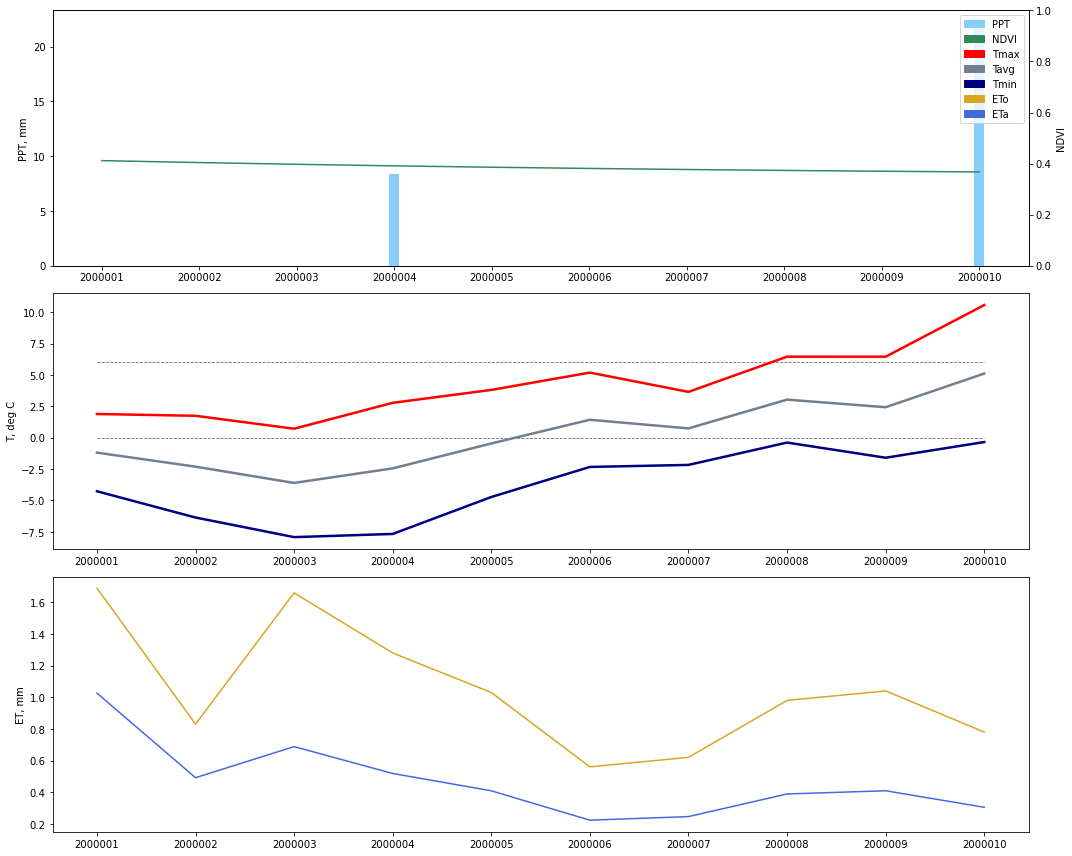

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(15,12))

axs[0].bar(df_validation.index, df_validation["PPT"], color = 'lightskyblue', width = 0.1)
ax0 = axs[0].twinx()
ax0.plot(df_validation.index, df_validation["NDVI"], color = 'seagreen')
axs[0].set_ylabel("PPT, mm")
ax0.set_ylabel("NDVI")
ax0.set_ylim([0,1])
#axs[0].set_xlim([df_veget.index[0], df_veget.index[-1]])
#ax0.set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[0].set_xticks(axs[0].get_xticks()[::10])
#ax0.set_xticks(ax0.get_xticks()[::10])

low_threshold = np.array([0 for i in range(len(df_validation))])
axs[1].plot(df_validation.index, low_threshold,  '--', color = 'dimgray', linewidth=0.8)
high_threshold = np.array([6 for i in range(len(df_validation))])
axs[1].plot(df_validation.index, high_threshold,  '--', color = 'dimgray', linewidth=0.8)
axs[1].plot(df_validation.index, df_validation["Tasmin"], color = 'navy', linewidth=2.5)
axs[1].plot(df_validation.index, df_validation["Tasavg"], color = 'slategray', linewidth=2.5)
axs[1].plot(df_validation.index, df_validation["Tasmax"], color = 'red', linewidth=2.5)
axs[1].set_ylabel("T, deg C")
#axs[1].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[1].set_xticks(axs[1].get_xticks()[::10])


axs[2].plot(df_validation.index, df_validation["ETo"], color = 'goldenrod')
axs[2].plot(df_validation.index, df_validation["etasw"], color = 'royalblue')
axs[2].set_ylabel("ET, mm")
#axs[2].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[2].set_xticks(axs[2].get_xticks()[::10])

ppt = mpatches.Patch(color='lightskyblue', label='PPT')
ndvi = mpatches.Patch(color='seagreen', label='NDVI')
tmax = mpatches.Patch(color='red', label='Tmax')
tavg = mpatches.Patch(color='slategray', label='Tavg')
tmin = mpatches.Patch(color='navy', label='Tmin')
eto = mpatches.Patch(color='goldenrod', label='ETo')
eta = mpatches.Patch(color='royalblue', label='ETa')
plt.legend(handles=[ppt, ndvi, tmax, tavg, tmin, eto,eta])

#fig.autofmt_xdate()
plt.tight_layout()
#fig.savefig('DRB{}_{}_input.png'.format(str(x),str(y)), dpi=300, format='png', frameon=True)

### Compare Veg ET output variables computed with data frames vs output variables computed in the cloud

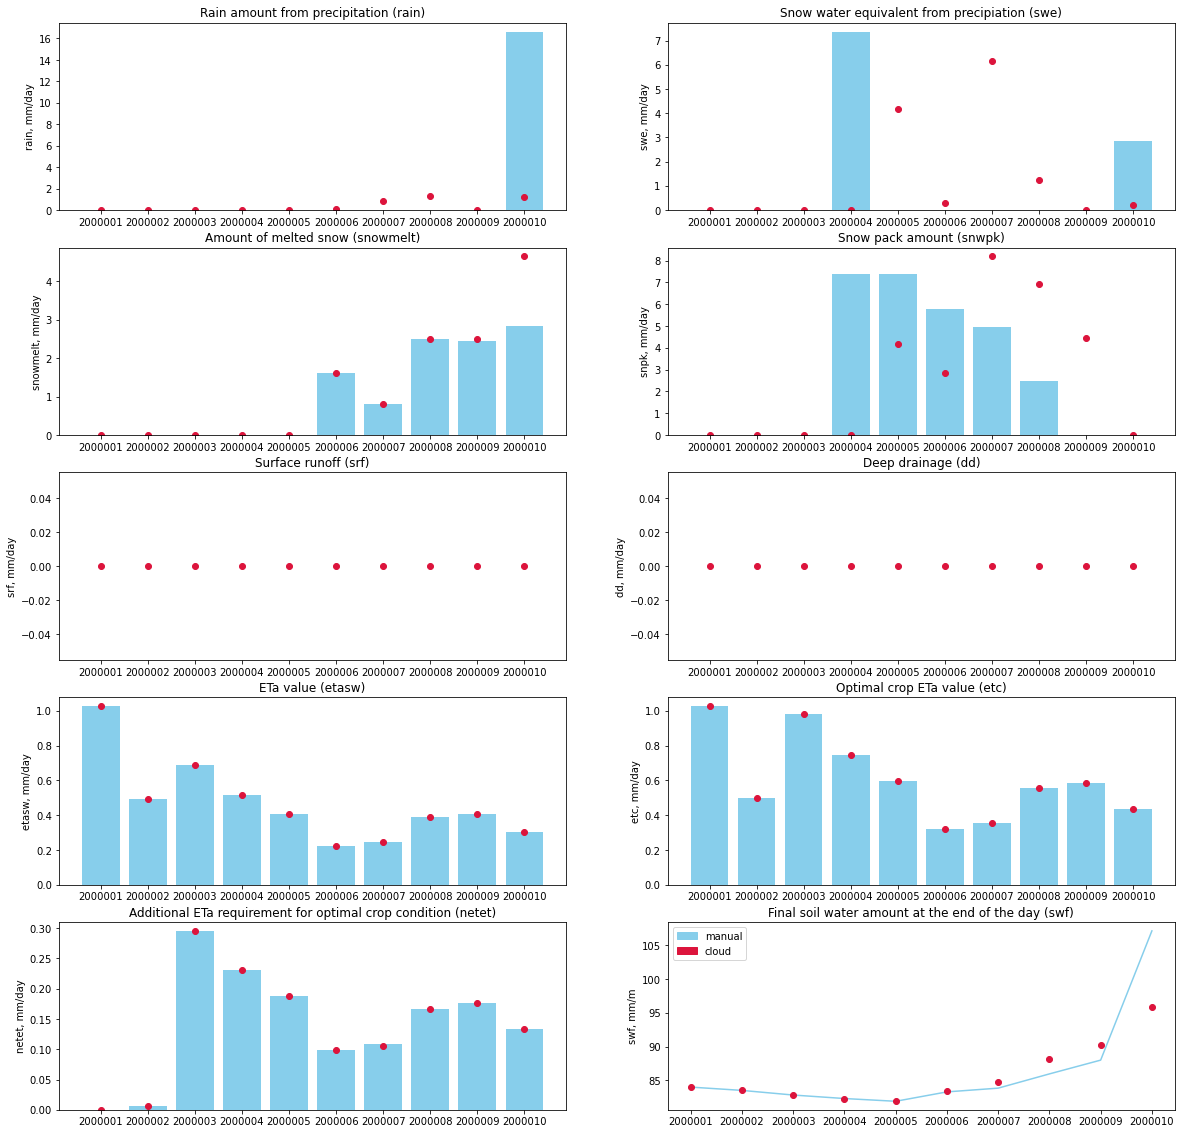

In [24]:
fig, axs = plt.subplots(5, 2, figsize=(20,20))


axs[0, 0].bar(df_validation.index, df_validation["rain"], color = 'skyblue')
axs[0, 0].plot(df_validation.index, df_validation["rain_cloud"], 'ro', color = 'crimson')
axs[0, 0].set_title("Rain amount from precipitation (rain)")
axs[0, 0].set_ylabel("rain, mm/day")
#axs[0, 0].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[0, 0].set_xticks(axs[0, 0].get_xticks()[::30])


axs[0, 1].bar(df_validation.index, df_validation["swe"], color = 'skyblue')
axs[0, 1].plot(df_validation.index, df_validation["swe_cloud"], 'ro', color = 'crimson')
axs[0, 1].set_title("Snow water equivalent from precipiation (swe)")
axs[0, 1].set_ylabel("swe, mm/day")
#axs[0, 1].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[0, 1].set_xticks(axs[0, 1].get_xticks()[::30])

axs[1, 0].bar(df_validation.index, df_validation["snowmelt"], color = 'skyblue')
axs[1, 0].plot(df_validation.index, df_validation["snowmelt_cloud"], 'ro', color = 'crimson')
axs[1, 0].set_title("Amount of melted snow (snowmelt)")
axs[1, 0].set_ylabel("snowmelt, mm/day")
#axs[1, 0].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[1, 0].set_xticks(axs[1, 0].get_xticks()[::30])


axs[1, 1].bar(df_validation.index, df_validation["snwpk"], color = 'skyblue')
axs[1, 1].plot(df_validation.index, df_validation["snwpk_cloud"], 'ro', color = 'crimson')
axs[1, 1].set_title("Snow pack amount (snwpk)")
axs[1, 1].set_ylabel("snpk, mm/day")
#axs[1, 1].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[1, 1].set_xticks(axs[1, 1].get_xticks()[::30])



axs[2, 0].bar(df_validation.index, df_validation["srf"], color = 'skyblue')
axs[2, 0].plot(df_validation.index, df_validation["srf_cloud"], 'ro', color = 'crimson')
axs[2, 0].set_title("Surface runoff (srf)")
axs[2, 0].set_ylabel("srf, mm/day")
#axs[2, 0].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[2, 0].set_xticks(axs[2, 0].get_xticks()[::30])


axs[2, 1].bar(df_validation.index, df_validation["dd"], color = 'skyblue')
axs[2, 1].plot(df_validation.index, df_validation["dd_cloud"], 'ro', color = 'crimson')
axs[2, 1].set_title("Deep drainage (dd)")
axs[2, 1].set_ylabel("dd, mm/day")
#axs[2, 1].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[2, 1].set_xticks(axs[2, 1].get_xticks()[::30])


axs[3, 0].bar(df_validation.index, df_validation["etasw"], color = 'skyblue')
axs[3, 0].plot(df_validation.index, df_validation["etasw_cloud"], 'ro', color = 'crimson')
axs[3, 0].set_title("ETa value (etasw)")
axs[3, 0].set_ylabel("etasw, mm/day")
#axs[3, 0].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[3, 0].set_xticks(axs[3, 0].get_xticks()[::30])



axs[3, 1].bar(df_validation.index, df_validation["etc"], color = 'skyblue')
axs[3, 1].plot(df_validation.index, df_validation["etc_cloud"], 'ro', color = 'crimson')
axs[3, 1].set_title("Optimal crop ETa value (etc)")
axs[3, 1].set_ylabel("etc, mm/day")
#axs[3, 1].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[3, 1].set_xticks(axs[3, 1].get_xticks()[::30])



axs[4, 0].bar(df_validation.index, df_validation["netet"], color = 'skyblue')
axs[4, 0].plot(df_validation.index, df_validation["netet_cloud"], 'ro', color = 'crimson')
axs[4, 0].set_title("Additional ETa requirement for optimal crop condition (netet)")
axs[4, 0].set_ylabel("netet, mm/day")
#axs[4, 0].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[4, 0].set_xticks(axs[4, 0].get_xticks()[::30])


axs[4, 1].plot(df_validation.index, df_validation["swf"], color = 'skyblue')
axs[4, 1].plot(df_validation.index, df_validation["swf_cloud"], 'ro', color = 'crimson')
axs[4, 1].set_title("Final soil water amount at the end of the day (swf)")
axs[4, 1].set_ylabel("swf, mm/m")
#axs[4, 1].set_xlim([df_veget.index[0], df_veget.index[-1]])
#axs[4, 1].set_xticks(axs[4, 1].get_xticks()[::30])

manual = mpatches.Patch(color='skyblue', label='manual')
cloud = mpatches.Patch(color='crimson', label='cloud')
plt.legend(handles=[manual,cloud])
#fig.savefig('test.png', dpi=300, format='png', frameon=True)
#fig.autofmt_xdate()
#plt.tight_layout()
#fig.savefig('DRB{}_{}_output.png'.format(str(x),str(y)), dpi=300, format='png', frameon=True)